In [1]:
import xml.etree.ElementTree
import os,glob,sys

%load_ext autoreload
%autoreload 2



In [2]:
MZMINE_COMMAND = '/Users/simon/MZmine-2.40.1/startMZmine_MacOSX.command'
MNET_PATH = '/Users/simon/git/molnet/code/'

Add the mol net code to the path (github.com/sdrogers/molnet)

In [3]:
sys.path.append(MNET_PATH)

## Example workflow

1. Load template xml
2. Find all input files in particular folder
3. For each file
    1. Create correct temporary xml
    2. Invoke mzmine
    

## Peak picking

- The following block grabs all of the raw files in a certain directory and then runs all of the peak picking steps
- Takes some time!


In [6]:
# Directory holding mzml files of interest
input_dir = '/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/multifile_ms2lda_manuscript/Supporting_Files/data/urines/'
# grab the list -- in this case all the T10 mzML files
file_list = glob.glob(os.path.join(input_dir,'*T10*.mzML'))

# # Directory to store all output
output_dir = '/Users/simon/git/pymzmine/ms2'
# output_dir = '/Users/simon/git/pymzmine/filter_test'

In [7]:
from mzmine import pick_peaks
pick_peaks(file_list[:3],output_dir=output_dir,mzmine_command=MZMINE_COMMAND)

Creating xml batch file for Urine_StrokeDrugs_105_T10_POS.mzML
Running mzMine for Urine_StrokeDrugs_105_T10_POS.mzML
Creating xml batch file for Urine_StrokeDrugs_58_T10_POS.mzML
Running mzMine for Urine_StrokeDrugs_58_T10_POS.mzML
Creating xml batch file for Urine_StrokeDrugs_18_T10_POS.mzML
Running mzMine for Urine_StrokeDrugs_18_T10_POS.mzML


## Optional: filter out duplicate ions

In [ ]:
from mzmine import filter_duplicates
output_dir = '/Users/simon/git/pymzmine/filter_test/'
new_output_dir = '/Users/simon/git/pymzmine/filter_test_out'
filter_duplicates(file_list[:3],output_dir,new_output_dir)
output_dir = new_output_dir

### Do some QC check of filtered ions

plot repetitive ions for one spectrum

In [ ]:
from mzmine import find_spectral_groups
groups = find_spectral_groups(file_list[0])

In [ ]:
def plot_groups(clusters,min_cluster_size):
    rt_diffs = []
    plt.figure(figsize=(15,10))
    cols = ['r','g','b','k','y','m']
    col_pos = 0
    for pmz,clu in clusters.items():
        for c in clu:
            if c.n_spectra >= min_cluster_size:
                for s in c.spectra:
                    mz = s.precursor_mz
                    rt = s.rt
#                     print(mz,rt)
                    plt.plot(rt,mz,cols[col_pos]+'o')
                col_pos += 1
            if col_pos == len(cols):
                col_pos = 0
            rt = [s.rt for s in c.spectra]
            rt.sort()
            rt_delta = [rt[i+1]-rt[i] for i,_ in enumerate(rt[:-1])]
            rt_diffs += rt_delta
    return rt_diffs

In [ ]:
import pylab as plt
%matplotlib inline
rt_diffs = plot_groups(groups,10)

In [ ]:
plt.figure(figsize=(10,10))
a = plt.hist(rt_diffs,bins = 500)
plt.xlim([0,50])

plot delta MZ histogram of filtered vs non-filtered spectrum

In [ ]:
from mnet_utilities import load_mgf
specmgf = load_mgf('4_60.mgf')

create clusters

In [ ]:
from mnet import Cluster
# create a cluster list
cluster_l = []
for ap,cl in specmgf.items():
    if cl:
        cluster_l.append(Cluster(cl, cl.scan_number))
print("Created list of {} clusters".format(len(cluster_l)))

get molecular families

In [ ]:
from mnet import mol_network
from scoring_functions import fast_cosine_shift
fam,mfam = mol_network(cluster_l,fast_cosine_shift,0.2,2,0.7)

get pair-wise parent m/z for unfiltered spectrum

In [ ]:
pmasses = []
for f in mfam:
    #print(f)
    #print(ff)
    for ff in f.scores:
        pm = []
        for fff in ff[:2]:
            #print(fff.parent_mz)
            pm.append(fff.parent_mz)
        pmasses.append(pm)

get pair-wise parent m/z for filtered spectrum

In [ ]:
import pandas as pd
filfile = pd.read_csv('4_60_quant.csv', sep = ',')

In [ ]:
pmassesfiltered = []
for f in mfam:
    #print(f)
    #print(ff)
    for ff in f.scores:
        pmf = []
        for fff in ff[:2]:
            #print(fff.parent_mz)
            if fff.cluster_id in list(filfile['row ID']):
                pmf.append(fff.parent_mz)
            else:
                print('not in file')
                print(fff.cluster_id)
                print(fff.parent_mz)
        pmassesfiltered.append(pmf)

calculate delta MZ for all pairs for unfiltered and filtered spectrum

In [ ]:
deltamzs = []
for l in pmasses:
    deltamzs.append(round(abs(l[0]-l[1]),2))

In [ ]:
deltamzsfiltered = []
for l in pmassesfiltered:
    if (len(l) == 2):
        deltamzsfiltered.append(round(abs(l[0]-l[1]),2))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
n, bins, patches = plt.hist(deltamzsfiltered, bins=len(set(deltamzsfiltered)),rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('MZ Delta')
plt.ylabel('Pairs')
plt.title('MZ Delta Histogram')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
n, bins, patches = plt.hist(deltamzs, bins=len(set(deltamzs)),rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('MZ Delta')
plt.ylabel('Pairs')
plt.title('MZ Delta Histogram')

## Alignment

- The following block loads the mztab files from a user-specified folder and runs the align algorithm, exporting results to a csv file

In [9]:
from mzmine import align
# mztab_folder = '/Users/simon/git/pymzmine/batch20/new_files'
# point this method to the folder that holds the mztabs you want to align
align(output_dir,mzmine_command = MZMINE_COMMAND)

['/Users/simon/git/pymzmine/ms2/Urine_StrokeDrugs_105_T10_POS_pp.mzTab', '/Users/simon/git/pymzmine/ms2/Urine_StrokeDrugs_18_T10_POS_pp.mzTab', '/Users/simon/git/pymzmine/ms2/Urine_StrokeDrugs_58_T10_POS_pp.mzTab']


## Creating the matching table

 - Matches aligned peaks back to their originals

In [10]:
from mzmine import load_aligned_peaks
# output_dir = '/Users/simon/git/pymzmine/batch20/output_subset'
output_dir = '/Users/simon/git/pymzmine/ms2'
print(output_dir)
aligned_peaks,original_files,f_idx_dict = load_aligned_peaks(output_dir)

/Users/simon/git/pymzmine/ms2


In [11]:
print(original_files)

['Urine_StrokeDrugs_58_T10_POS', 'Urine_StrokeDrugs_105_T10_POS', 'Urine_StrokeDrugs_18_T10_POS']


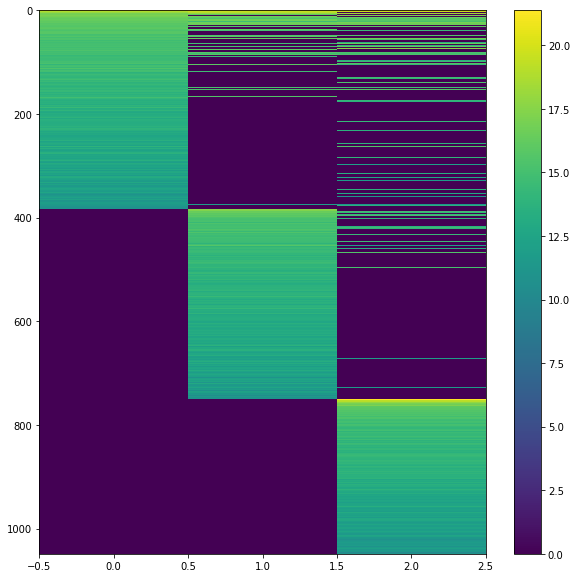

In [12]:
import numpy as np
intensities = np.array([list(a[3]) for a in aligned_peaks])
import pylab as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(np.log(intensities+1),aspect='auto')
plt.colorbar()

- Do the matching (entirely based on intensity)
- Output of this next cell is a dictionary `matches`
- Keys are aligned peaks, values are dictionaries...
    - keys are original files, values are IDs in the original files

In [13]:
from mzmine import match_aligned_to_original
matches = match_aligned_to_original(aligned_peaks,original_files,output_dir,f_idx_dict,write_file = True)

In [110]:
from mnet_utilities import load_mgf
specmgf = load_mgf(os.path.join(output_dir,'Urine_StrokeDrugs_105_T10_POS.mgf'))

id_1 = list(specmgf.keys())[1]
print(id_1) # peak id in specific file
# find this in matches to get the mz / rt
for aligned_peak,values in matches.items():
    possible = values.get('Urine_StrokeDrugs_105_T10_POS',None)
    if possible:
        if possible[0] == id_1:
            break
print(possible)
print(possible[2]*60)

154
(154, 314.2323303222656, 7.056583333333333, 162281175.3416876)
423.395


So, it seems that mzmine puts the MS1 RT into the MS2 scan

In [111]:
# some example code to get the exact MS2 RT
file_name = 'Urine_StrokeDrugs_105_T10_POS'
peak_id = 144
peak_details = possible # get this from the file
peak_mz = possible[1]
peak_rt = possible[2]

full_file_name = os.path.join(input_dir,file_name + '.mzML')
import pymzml
reader = pymzml.run.Reader(full_file_name)
for spectrum in reader:
    rt = spectrum.scan_time_in_minutes()
    if spectrum.ms_level == 2:
        precursor_dict = spectrum.selected_precursors[0]
        mz = precursor_dict['mz']
        if(abs(mz-peak_mz) < 1e-5) and abs(rt-peak_rt)<0.5:
            print(mz,rt*60.0) # true RT

/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/multifile_ms2lda_manuscript/Supporting_Files/data/urines/Urine_StrokeDrugs_105_T10_POS.mzML


Todo:
- load all data
- For each ms2 of interest
    - Find its true rt
    - Find as many observations of its ms1 intensity and rt as possible (go back and fwd scans) 

In [112]:
reader = pymzml.run.Reader(full_file_name)
all_spec = []
scan_no = 0
for spectrum in reader:
    spec = {'scan_no':scan_no}
    spec['rt'] = spectrum.scan_time_in_minutes()
    spec['ms_level'] = spectrum.ms_level
    if spec['ms_level'] == 2:
        spec['precursor_mz'] = spectrum.selected_precursors[0]['mz']
    spec['peaks'] = spectrum.peaks('centroided')
    all_spec.append(spec)
    scan_no += 1

/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/multifile_ms2lda_manuscript/Supporting_Files/data/urines/Urine_StrokeDrugs_105_T10_POS.mzML


In [113]:
def find_precursor(precursor_mz,peaks):
    mz,inte = zip(*peaks)
    mz = np.array(mz)
    err = abs(mz - precursor_mz)
    pos = np.argmin(err)
    if err[pos] < 1e-3: # fix me
        return mz[pos],inte[pos]
    else:
        return None

[(7.0341, 314.2324, 5960596.0), (7.056583333333333, 314.23233, 54740708.0), (7.077566666666667, 314.23233, 38340800.0), (7.097083333333333, 314.23236, 10662276.0), (7.12015, 314.23227, 2919678.8), (7.142483333333333, 314.23257, 1462887.2)]


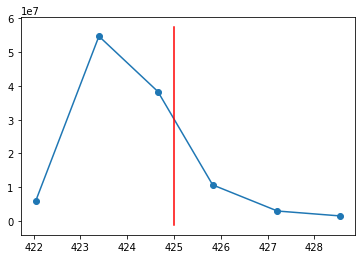

In [115]:

def find_ms2(all_spec,mz,rt):
    # find all ms2 scans within 1e-4 of mz
    pos = []
    for i,s in enumerate(all_spec):
        if s['ms_level'] == 2:
            err = abs(mz - s['precursor_mz'])
            rt_err = abs(rt - s['rt'])
            if err < 1e-4 and rt_err < 0.5:
                pos.append(i)
    if len(pos) == 1:
        return pos[0]
    else:
        errs = [abs(mz-all_spec[p]['precursor_mz']) for p in pos]
        errs = np.array(errs)
        best_pos = np.argmin(errs)
        return pos[best_pos]

pos = find_ms2(all_spec,peak_mz,peak_rt)
# move back looking for precursors
ok = True
temp_pos = pos
this_data = []
found = 0
while ok:
    if temp_pos == 0:
        break
    if all_spec[temp_pos]['ms_level'] == 2:
        temp_pos -= 1
        continue
    # it's an MS1
    precu = find_precursor(peak_mz,all_spec[temp_pos]['peaks'])
    if precu:
        this_mz,this_intensity = precu
        this_data.append((all_spec[temp_pos]['rt'],this_mz,this_intensity))
        found += 1
    else:
        break
    temp_pos -= 1
    if found == 3:
        break
    
ok = True
temp_pos = pos
found = 0
while ok:
    if temp_pos == len(all_spec):
        break
    if all_spec[temp_pos]['ms_level'] == 2:
        temp_pos += 1
        continue
    # it's an MS1
    precu = find_precursor(peak_mz,all_spec[temp_pos]['peaks'])
    if precu:
        this_mz,this_intensity = precu
        this_data.append((all_spec[temp_pos]['rt'],this_mz,this_intensity))
        found += 1
    else:
        break
    temp_pos += 1
    if found == 3:
        break
    

this_data.sort(key = lambda x: x[0])
print(this_data)
r,m,i = zip(*this_data)
plt.plot(np.array(r)*60.0,i,'o-')
plt.plot([all_spec[pos]['rt']*60.0,all_spec[pos]['rt']*60.0],plt.ylim(),'r')

## Do some QC - check to find aligned peaks with spectra with low cosine similarity

In [14]:
from mzmine import compute_cosine_aligned_peaks
worst_matches = compute_cosine_aligned_peaks(aligned_peaks,original_files,output_dir,matches)

Loaded 24 spectra from Urine_StrokeDrugs_58_T10_POS
Loaded 25 spectra from Urine_StrokeDrugs_105_T10_POS
Loaded 26 spectra from Urine_StrokeDrugs_18_T10_POS
1000 1049


In [15]:
bad_lt_05 = list(filter(lambda x: x[-1] < 0.5,list(worst_matches.values())))
print("{} (of {} that have at least two spectra) have bad spectral matches (i.e. cosine < 0.5)".format(len(bad_lt_05),len(worst_matches)))

0 (of 16 that have at least two spectra) have bad spectral matches (i.e. cosine < 0.5)


In [117]:
def examine_aligned_peak(ap,matches,output_dir,original_files,spectra = None):
    from itertools import combinations
    from scoring_functions import fast_cosine
    if not spectra:
        spectra = {}
        from mnet_utilities import load_mgf
        for o in original_files:
            mgf_file = os.path.join(output_dir,o+'.mgf')
            spectra[o] = load_mgf(mgf_file)
            print("Loaded {} spectra from {}".format(len(spectra[o]),o))
    # look through the original files and see if they have spec
    individual_peaks = []
    n_peaks = 0
    n_with_spec = 0
    for f in matches[ap]:
        n_peaks += 1
        spec = None
        i_d,mz,rt,intensity = matches[ap][f]
        spec = spectra[f].get(i_d,None)
        individual_peaks.append((f,mz,rt,intensity,spec))
        if spec:
            n_with_spec += 1
    print("{} individual peaks, {} with spectra".format(n_peaks,n_with_spec))
    plt.figure(figsize=(15,10))
    mz_list = [p[1] for p in individual_peaks]
    rt_list = [p[2] for p in individual_peaks]
    plt.xlabel('RT')
    plt.ylabel('mz')
    for p1,p2 in combinations(individual_peaks,2):
        spec1 = p1[-1]
        spec2 = p2[-1]
        if spec1 and spec2:
            s,_ = fast_cosine(spec1,spec2,0.2,1)
            color = [1-s,0,s,0.3]
            plt.plot([p1[2],p2[2]],[p1[1],p2[1]],color = color,linewidth=2)
    plt.plot(rt_list,mz_list,'ko')
    plt.title('Edges show cosine score, red to blue = low to high score')
    return spectra

12 individual peaks, 6 with spectra


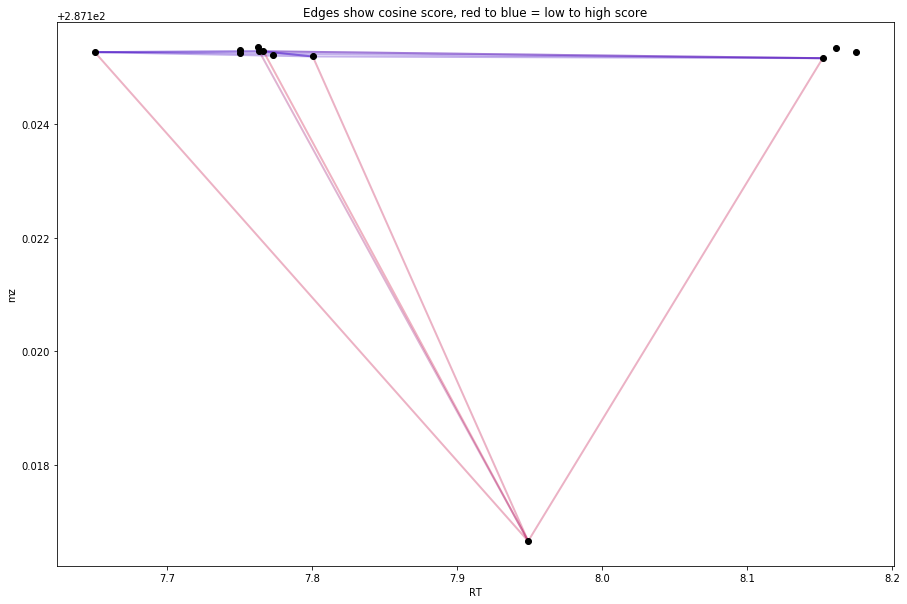

In [120]:
idx = 10
ap = has_lt_05[idx]
# print(ap)
spectra = examine_aligned_peak(ap,matches,
                               output_dir,
                               original_files,
                               spectra = spectra)

Look at all peak groups and compute the max rt and mz deviation (distance from mean)


In [221]:
def find_deviations(aligned_peaks,matches,output_dir,original_files,spectra = None):
    from itertools import combinations
    n_done = 0
    
    if not spectra:
        spectra = {}
        from mnet_utilities import load_mgf
        for o in original_files:
            mgf_file = os.path.join(output_dir,o+'.mgf')
            spectra[o] = load_mgf(mgf_file)
            print("Loaded {} spectra from {}".format(len(spectra[o]),o))
    
    
    good_mz_dev = []
    good_rt_dev = []
    bad_mz_dev = []
    bad_rt_dev = []
    min_s = 0.5
    
    good_mz_diffs = []
    good_rt_diffs = []
    bad_mz_diffs = []
    bad_rt_diffs = []
    
    for ap in aligned_peaks:
        match = matches[ap]
        individual_peaks = []
        for f in match:
            i_d,mz,rt,intensity = match[f]
            spec = spectra[f].get(i_d,None)
            if spec:
                individual_peaks.append((i_d,mz,rt,intensity,spec))
        if len(individual_peaks) == 0:
            continue
        mz_array = np.array([p[1] for p in individual_peaks])
        rt_array = np.array([p[2] for p in individual_peaks])
        for p1,p2 in combinations(individual_peaks,2):
            s,_ = fast_cosine(p1[-1],p2[-1],1,0.2)
            if s < min_s:
                bad_mz_diffs.append((p1[1]-p2[1],s))
                bad_rt_diffs.append((60.0*(p1[2]-p2[2]),s))
            else:
                good_mz_diffs.append((p1[1]-p2[1],s))
                good_rt_diffs.append((60.0*(p1[2]-p2[2]),s))

        n_done += 1
        if n_done % 1000 == 0:
            print(n_done)
    return np.array(good_mz_diffs),np.array(good_rt_diffs),np.array(bad_mz_diffs),np.array(bad_rt_diffs)
        

In [222]:
gmd,grd,bmd,brd = find_deviations(aligned_peaks,matches,output_dir,original_files,spectra = spectra)


1000
2000
3000
4000


0.9871557986600833
1.8058191922979185

0.00011200238161218761
0.0003857270689476855


Text(0.5, 1.0, 'RT')

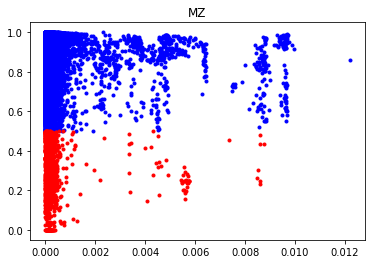

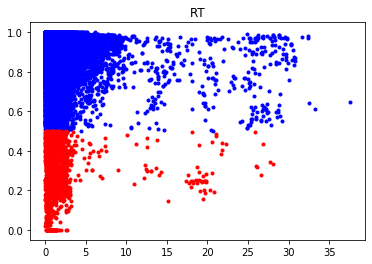

In [223]:
print(abs(grd[:,0]-grd[:,0].mean()).mean())
print(abs(brd[:,0]-brd[:,0].mean()).mean())
print()
print(abs(gmd[:,0]-gmd[:,0].mean()).mean())
print(abs(bmd[:,0]-bmd[:,0].mean()).mean())

allmd = np.vstack((gmd,bmd))
plt.plot(np.abs(gmd[:,0]),gmd[:,1],'b.')
plt.plot(np.abs(bmd[:,0]),bmd[:,1],'r.')
plt.title('MZ')
plt.figure()
plt.plot(np.abs(grd[:,0]),grd[:,1],'b.')
plt.plot(np.abs(brd[:,0]),brd[:,1],'r.')
plt.title('RT')




(-10, 10)

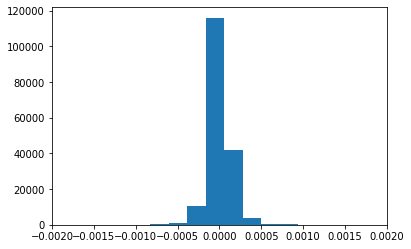

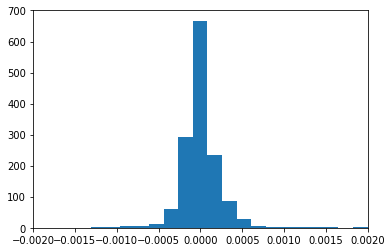

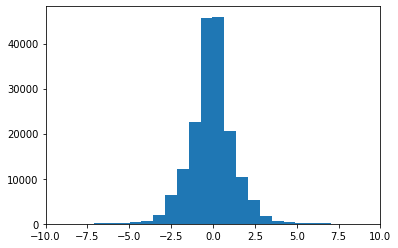

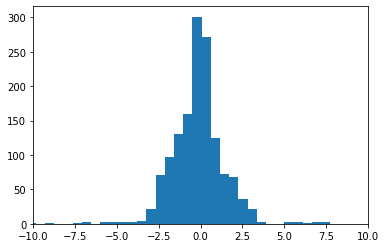

In [224]:
plt.figure()
h = plt.hist(gmd[:,0],bins=100)
plt.xlim([-0.002,0.002])
plt.figure()
h = plt.hist(bmd[:,0],bins=100)
plt.xlim([-0.002,0.002])


plt.figure()
h = plt.hist(grd[:,0],bins=100)
plt.xlim([-10,10])
plt.figure()
h = plt.hist(brd[:,0],bins=100)
plt.xlim([-10,10])


Find an aligned peak with a cosine score < 0.5 and plot a bar chart of intensity, highlighting the bad one

2_03 8565801.556410966
2_60 13068285.461918453


[0.36630605 0.24007957 0.78560154 0.64369489 0.         0.19618379
 0.37447253 0.0228095  0.86208812 0.80250248 0.64560234 0.34811016
 0.6627309  0.41514966 0.07562736 0.89651217 1.         0.05885881
 0.55322627 0.46750787]


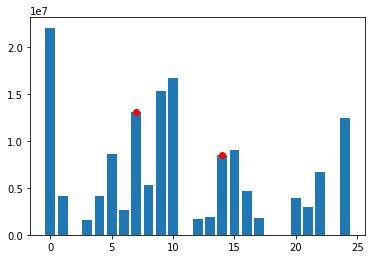

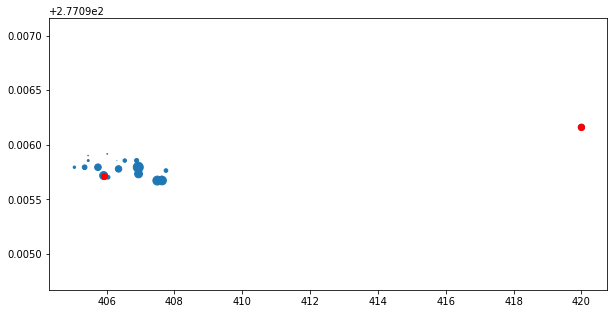

<Figure size 432x288 with 0 Axes>

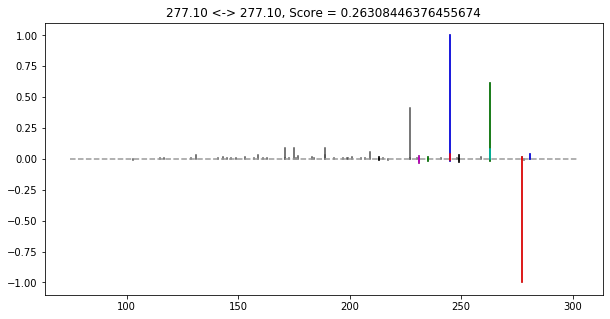

In [31]:
has_lt_05 = []
for ap in worst_matches:
    # this stores the worst match
    this_match = worst_matches[ap]
    if this_match[-1] > 0.3:
        continue
    has_lt_05.append(ap)
    

idx = 19
ap = has_lt_05[idx]
this_match = worst_matches[ap]
file1 = this_match[0]
file2 = this_match[1]
n_files = len(ap[3])
plt.bar(range(n_files),ap[3])
pos1 = f_idx_dict[file1]
pos2 = f_idx_dict[file2]
plt.plot(pos1,ap[3][pos1],'ro')
plt.plot(pos2,ap[3][pos2],'ro')
print(file1,ap[3][pos1])
print(file2,ap[3][pos2])
print()
print()

mz_list = []
rt_list = []
inte_list = []
for f in f_idx_dict:
    pos = f_idx_dict[f]
    match = matches[ap].get(f,None)
    if match:
        mz_list.append(match[1])
        rt_list.append(match[2]*60)
        inte_list.append(match[3])

plt.figure(figsize=(10,5))
ll = np.log(inte_list)
ll -= ll.min()
ll/=ll.max()
plt.scatter(rt_list,mz_list,s = 100*ll**2,marker='o')
mz1 = matches[ap][file1][1]
mz2 = matches[ap][file2][1]
rt1 = matches[ap][file1][2]*60
rt2 = matches[ap][file2][2]*60
plt.plot(rt1,mz1,'ro')
plt.plot(rt2,mz2,'ro')
plt.ylim([min(mz_list)-1e-3,max(mz_list)+1e-3])
print(ll)
plt.figure()
from mnet import plot_spectral_alignment
from scoring_functions import fast_cosine
plot_spectral_alignment(this_match[-2],this_match[-3],fast_cosine,0.2,figsize=(10,5))
# plot_spectrum_pair(this_match[-2].normalised_peaks,this_match[-3].normalised_peaks)

In [ ]:
?plt.scatter

In [ ]:
print(worst_matches[aligned_peaks[0]])

In [ ]:
# can plot the spectral pairs that have the lowest cosine for each aligned peak group
# for example, the first five groups
# (note plotting normalised peaks is best)
from mnet import plot_spectrum_pair
for example_ap in list(worst_matches.keys())[:5]:
    bh = worst_matches[example_ap]
    plot_spectrum_pair(bh[-3].normalised_peaks,bh[-2].normalised_peaks)
    plt.title('Cosine = {}'.format(bh[-1]))

In [ ]:
# can plot the worst cosine as a function of rt although there is no obvious pattern!
rt_list = []
sc_list = []
for ap in worst_matches:
    rt_list.append(ap[2])
    sc_list.append(worst_matches[ap][-1])
plt.figure(figsize=(10,10))
plt.plot(rt_list,sc_list,'bo')

## Create a single mgf for the dataset -- keep the best spectrum from each file

- Best is defined as the one with maximum total intensity
- MGF has the mz and rt from the original file, not the aligned peak
- MGF also includes the filename that the best spectrum comes from

In [ ]:
from mzmine import align_spectra
spec_clusters = align_spectra(aligned_peaks,original_files,output_dir,matches = matches,make_mgf = True)

## Spectral library matching

In [ ]:
from spec_lib import SpecLib
from scoring_functions import fast_cosine
import jsonpickle
processed_lib_file = '/Users/simon/git/molnet/lib/ALL_GNPS.p'
with open(processed_lib_file,'r') as f:
    all_gnps = jsonpickle.decode(f.read())
    

In [ ]:
from mnet import Annotation
n_done = 0
for ap,cl in spec_clusters.items():
    if n_done % 100 == 0:
        print(n_done)
    if cl:
        hits = all_gnps.spectral_match(cl.spectrum,fast_cosine)
        if len(hits) > 0:
            hits.sort(key = lambda x: x[1], reverse = True)
            if not 'annotation' in cl.spectrum.metadata:
                cl.spectrum.metadata['annotation'] = []
            for hit in hits:
                temp_dict = {}
                temp_dict['SpectrumID'] = hit[0]
                temp_dict['score'] = hit[1]
                temp_dict['Compound_Name'] = all_gnps.spectra[hit[0]].metadata['NAME']
                cl.spectrum.metadata['annotation'].append(Annotation(temp_dict))
    n_done += 1

In [ ]:
n_found = 0
for ap,cl in spec_clusters.items():
    if cl:
        if cl.spectrum.metadata.get('annotation',None):
            # get the annotation
            anns = cl.spectrum.metadata.get('annotation')
            for ann in anns:
                print(cl.cluster_id,str(ann))
            n_found += 1
            if n_found == 10:
                break

In [ ]:
print(ann.metadata.keys())

## Easy now to do molecular networking

In [ ]:
# create a cluster list
cluster_list = []
for ap,cl in spec_clusters.items():
    if cl:
        cluster_list.append(cl)
print("Created list of {} clusters".format(len(cluster_list)))

In [ ]:
from mnet import mol_network
from scoring_functions import fast_cosine_shift
fam,mfam = mol_network(cluster_list,fast_cosine_shift,0.2,2,0.7)

In [ ]:
# create a list of files and lists of peak areas for each cluster to add to node file
# extra_node_data is a list of tuples. The first in the tuple is the list to add to the file headings
# the second is a dictionary with cluster ids as keys and the cluster-specific lists to add to the file as values
peak_areas = {}
extra_node_data = []
aligned_peak_dict = {a[0]:a[3] for a in aligned_peaks}
f_idx_list = list(f_idx_dict.keys())
for cl in cluster_list:
    peak_areas[cl.cluster_id] = []
    for o in f_idx_list:
        peak_areas[cl.cluster_id].append(aligned_peak_dict[cl.cluster_id][f_idx_dict[o]])
extra_node_data.append(([f + ' peak area' for f in f_idx_list],peak_areas))

Compute DE between m and f. Note metadata is in `md_json.p`

Add annotations

In [ ]:
annotation_dict = {}
from mnet import Cluster
for cl in cluster_list:
    ann = cl.annotation
    if ann:
        annotation_dict[cl.cluster_id] = [str(ann)]
    else:
        annotation_dict[cl.cluster_id] = [""]
extra_node_data.append((['annotation'],annotation_dict))

In [ ]:
from mnet import write_mnet_files
write_mnet_files(mfam,os.path.join(output_dir,'mnet'),{},write_mgf = False,pickle = False,extra_node_data = extra_node_data)

write graphml file

In [ ]:
from mnet_utilities import write_mnet_graphml

In [ ]:
G = write_mnet_graphml(mfam,os.path.join(output_dir,'mnet'),metadata = None,extra_node_data = extra_node_data)

In [ ]:
nx.write_graphml(G, os.path.join(output_dir,"EdgesNodes.graphml"), infer_numeric_types = True)